In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import cv2
#import pandas as pd
import os
import numpy as np
#import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import *
import time
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Softmax
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing import image
import keras.backend as K
!pip install keras_applications

import keras_applications
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils.layer_utils import get_source_inputs
print("All modules have been imported")

All modules have been imported


In [2]:
scale_percent = 100 # percent of original size
width = int(np.round(600 * scale_percent / 100))
height = int(np.round(300 * scale_percent / 100))
dim = (width, height)

###############################<br>
# ResNet50 Model Definition ###<br>
###############################

In [3]:
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [4]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

In [5]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)
    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [6]:
def cvam_block(x,x1,x2, ratio=8):
  """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
  As described in https://arxiv.org/abs/1807.06521.
  """
  #print('before',x)
  c_map = channel_attention2(x,x2, ratio)
  #print ('after',x_enhanced)
  s_map = spatial_attention2(x,x1)
  return multiply([x, 1+s_map,1+c_map])
  #x=RMLO
  #x1=LMLO
  #x2=RCC
  #x3=LCC
def channel_attention2(x,x2, ratio=8):
  features=[x,x2]
  channel_axis = 1 if K.image_data_format() == "channels_first" else -1
  channel = x.shape[channel_axis]	
  #channel = input_feature.shape
  shared_layer_one = Dense(channel//ratio,
              activation='relu',
              kernel_initializer='he_normal',
              use_bias=True,
              bias_initializer='zeros')
  shared_layer_two = Dense(channel,
              kernel_initializer='he_normal',
              use_bias=True,
              bias_initializer='zeros')

  avg_pool = GlobalAveragePooling2D()(x)    
  avg_pool = Reshape((1,1,channel))(avg_pool)
  assert avg_pool.shape[1:] == (1,1,channel)
  avg_pool = shared_layer_one(avg_pool)
  assert avg_pool.shape[1:] == (1,1,channel//ratio)
  avg_pool = shared_layer_two(avg_pool)
  assert avg_pool.shape[1:] == (1,1,channel)

  max_pool = GlobalMaxPooling2D()(x)
  max_pool = Reshape((1,1,channel))(max_pool)
  assert max_pool.shape[1:] == (1,1,channel)
  max_pool = shared_layer_one(max_pool)
  assert max_pool.shape[1:] == (1,1,channel//ratio)
  max_pool = shared_layer_two(max_pool)
  assert max_pool.shape[1:] == (1,1,channel)

  avg_pool1 = GlobalAveragePooling2D()(x2)    
  avg_pool1 = Reshape((1,1,channel))(avg_pool1)
  assert avg_pool1.shape[1:] == (1,1,channel)
  avg_pool1 = shared_layer_one(avg_pool1)
  assert avg_pool1.shape[1:] == (1,1,channel//ratio)
  avg_pool1 = shared_layer_two(avg_pool1)
  assert avg_pool1.shape[1:] == (1,1,channel)

  max_pool1 = GlobalMaxPooling2D()(x2)
  max_pool1 = Reshape((1,1,channel))(max_pool1)
  assert max_pool1.shape[1:] == (1,1,channel)
  max_pool1 = shared_layer_one(max_pool1)
  assert max_pool1.shape[1:] == (1,1,channel//ratio)
  max_pool1 = shared_layer_two(max_pool1)
  assert max_pool1.shape[1:] == (1,1,channel)

  concat = Concatenate(axis=3)([avg_pool, max_pool, avg_pool1, max_pool1])
  print('concat', concat)
  print('avg_pool',avg_pool)
  cbam_feature=Dense(x.shape[3])(concat)
  print ('after dense1',cbam_feature)
  cbam_feature = Activation('relu')(cbam_feature)
  cbam_feature=Dense(x.shape[3])(concat)
  print ('after dense2',cbam_feature)
  #sum = Add()([avg_pool,max_pool,avg_pool1,max_pool1])
  #print ('sum', sum)
  cbam_feature = Activation('sigmoid')(cbam_feature)
  print (cbam_feature)
  if K.image_data_format() == "channels_first":
    cbam_feature = Permute((3, 1, 2))(cbam_feature)
  
  return cbam_feature

def spatial_attention2(x,x1):
  kernel_size = 7
	
  if K.image_data_format() == "channels_first":
    channel = x.shape[1]
    cbam_feature = Permute((2,3,1))(x)
  else:
    channel = x.shape[-1]
    cbam_feature = x
	
  avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
  print ('avg pool v1',avg_pool)
  assert avg_pool.shape[-1] == 1
  max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
  assert max_pool.shape[-1] == 1

  if K.image_data_format() == "channels_first":
    channel = x1.shape[1]
    cbam_feature = Permute((2,3,1))(x1)
  else:
    channel = x1.shape[-1]
    cbam_feature = x1

  avg_pool1 = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(x1)
  print ('avg pool v2',avg_pool1)
  assert avg_pool1.shape[-1] == 1
  max_pool1 = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(x1)
  assert max_pool1.shape[-1] == 1

  concat = Concatenate(axis=3)([avg_pool, max_pool, avg_pool1, max_pool1])
  #concat = Concatenate(axis=3)([avg_pool, max_pool])
  assert concat.shape[-1] == 4
  cbam_feature = Conv2D(4, (3, 3), padding="same")(concat)
  cbam_feature = Activation('relu')(cbam_feature)	
  cbam_feature = Conv2D(1, (3, 3), padding="same")(cbam_feature)
  cbam_feature = Activation('sigmoid')(cbam_feature)
  #print (cbam_feature)	
  assert cbam_feature.shape[-1] == 1
  if K.image_data_format() == "channels_first":
    cbam_feature = Permute((3, 1, 2))(cbam_feature)
  #print (multiply([x, cbam_feature]))
  return cbam_feature

In [7]:
def MyResNet50(dimension,include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1):
    """Instantiates the ResNet50 architecture.
    Optionally loads weights pre-trained
    on ImageNet. Note that when using TensorFlow,
    for best performance you should set
    `image_data_format="channels_last"` in your Keras config
    at ~/.keras/keras.json.
    The model and the weights are compatible with both
    TensorFlow and Theano. The data format
    convention used by the model is the one
    specified in your Keras config file.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 244)` (with `channels_first` data format).
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 197.
            E.g. `(200, 200, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    #######################################
    ##### Determine proper input shape ####
    #######################################
    #input_shape = [dimension[0],dimension[1],4,3]
    #input_shape = [dimension[1],dimension[0],3,4]
    input_shape = [4,dimension[0],dimension[1],3]
    #print ("input_shape : ", input_shape)
    #print (input_tensor)
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    
    #print ('before',img_input)
    #input_tensor=input_tensor[:,:,:,:,0]
#     x  =img_input[0]
#     x1 =img_input[1]
#     x2 =img_input[2]
#     print (x2)
    x=img_input[:,0,:,:,:]
    x1=img_input[:,1,:,:,:]
    x2=img_input[:,2,:,:,:]
    
    x3=img_input[:,3,:,:,:]

    #print ('after',x)
    x = ZeroPadding2D((3, 3))(x)
    x1 = ZeroPadding2D((3, 3))(x1)
    x2 = ZeroPadding2D((3, 3))(x2)
    x3 = ZeroPadding2D((3, 3))(x3)
    #print ('first', x)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x1 = Conv2D(64, (7, 7), strides=(2, 2), name='conv1_1')(x1)
    x2 = Conv2D(64, (7, 7), strides=(2, 2), name='conv1_2')(x2)
    x3 = Conv2D(64, (7, 7), strides=(2, 2), name='conv1_3')(x3)

    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x1 = BatchNormalization(axis=bn_axis, name='bn_conv1_1')(x1)
    x2 = BatchNormalization(axis=bn_axis, name='bn_conv1_2')(x2)
    x3 = BatchNormalization(axis=bn_axis, name='bn_conv1_3')(x3)

    x = Activation('relu')(x)
    x1 = Activation('relu')(x1)
    x2 = Activation('relu')(x2)
    x3 = Activation('relu')(x3)

    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x1 = MaxPooling2D((3, 3), strides=(2, 2))(x1)
    x2 = MaxPooling2D((3, 3), strides=(2, 2))(x2)
    x3 = MaxPooling2D((3, 3), strides=(2, 2))(x3)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x1 = conv_block(x1, 3, [64, 64, 256], stage=2, block='a1', strides=(1, 1))
    x2 = conv_block(x2, 3, [64, 64, 256], stage=2, block='a2', strides=(1, 1))
    x3 = conv_block(x3, 3, [64, 64, 256], stage=2, block='a3', strides=(1, 1))

    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x1 = identity_block(x1, 3, [64, 64, 256], stage=2, block='b1')
    x2 = identity_block(x2, 3, [64, 64, 256], stage=2, block='b2')
    x3 = identity_block(x3, 3, [64, 64, 256], stage=2, block='b3')

    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    x1 = identity_block(x1, 3, [64, 64, 256], stage=2, block='c1')
    x2 = identity_block(x2, 3, [64, 64, 256], stage=2, block='c2')
    x3 = identity_block(x3, 3, [64, 64, 256], stage=2, block='c3')
    #print ('x1',x1.shape[3])
    
    #x = cbam_block(x)


    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x1 = conv_block(x1, 3, [128, 128, 512], stage=3, block='a1')
    x2 = conv_block(x2, 3, [128, 128, 512], stage=3, block='a2')
    x3 = conv_block(x2, 3, [128, 128, 512], stage=3, block='a3')

    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x1 = identity_block(x1, 3, [128, 128, 512], stage=3, block='b1')
    x2 = identity_block(x2, 3, [128, 128, 512], stage=3, block='b2')
    x3 = identity_block(x3, 3, [128, 128, 512], stage=3, block='b3')

    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x1 = identity_block(x1, 3, [128, 128, 512], stage=3, block='c1')
    x2 = identity_block(x2, 3, [128, 128, 512], stage=3, block='c2')
    x3 = identity_block(x3, 3, [128, 128, 512], stage=3, block='c3')

    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    x1 = identity_block(x1, 3, [128, 128, 512], stage=3, block='d1')
    x2 = identity_block(x2, 3, [128, 128, 512], stage=3, block='d2')
    x3 = identity_block(x3, 3, [128, 128, 512], stage=3, block='d3')

    #x = cbam_block(x)

    x = cvam_block(x,x1,x2)
    #x1 = cvam_block(x1,x,x3)
    #x2 = cvam_block(x2,x3,x)
    # x3 = cvam_block(x3,x2,x1)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x1 = conv_block(x1, 3, [256, 256, 1024], stage=4, block='a1')
    x2 = conv_block(x2, 3, [256, 256, 1024], stage=4, block='a2')
    x3 = conv_block(x3, 3, [256, 256, 1024], stage=4, block='a3')

    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x1 = identity_block(x1, 3, [256, 256, 1024], stage=4, block='b1')
    x2 = identity_block(x2, 3, [256, 256, 1024], stage=4, block='b2')
    x3 = identity_block(x3, 3, [256, 256, 1024], stage=4, block='b3')

    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x1 = identity_block(x1, 3, [256, 256, 1024], stage=4, block='c1')
    x2 = identity_block(x2, 3, [256, 256, 1024], stage=4, block='c2')
    x3 = identity_block(x3, 3, [256, 256, 1024], stage=4, block='c3')

    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x1 = identity_block(x1, 3, [256, 256, 1024], stage=4, block='d1')
    x2 = identity_block(x2, 3, [256, 256, 1024], stage=4, block='d2')
    x3 = identity_block(x3, 3, [256, 256, 1024], stage=4, block='d3')

    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x1 = identity_block(x1, 3, [256, 256, 1024], stage=4, block='e1')
    x2 = identity_block(x2, 3, [256, 256, 1024], stage=4, block='e2')
    x3 = identity_block(x3, 3, [256, 256, 1024], stage=4, block='e3')

    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    x1 = identity_block(x1, 3, [256, 256, 1024], stage=4, block='f1')
    x2 = identity_block(x2, 3, [256, 256, 1024], stage=4, block='f2')
    x3 = identity_block(x3, 3, [256, 256, 1024], stage=4, block='f3')

    #x = cbam_block(x)
    x = cvam_block(x,x1,x2)
    #x1 = cvam_block(x1,x,x3)
    #x2 = cvam_block(x2,x3,x)
    # x3 = cvam_block(x3,x2,x1)

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x1 = conv_block(x1, 3, [512, 512, 2048], stage=5, block='a1')
    x2 = conv_block(x2, 3, [512, 512, 2048], stage=5, block='a2')
    x3 = conv_block(x3, 3, [512, 512, 2048], stage=5, block='a3')

    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x1 = identity_block(x1, 3, [512, 512, 2048], stage=5, block='b1')
    x2 = identity_block(x2, 3, [512, 512, 2048], stage=5, block='b2')
    x3 = identity_block(x3, 3, [512, 512, 2048], stage=5, block='b3')

    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    x1 = identity_block(x1, 3, [512, 512, 2048], stage=5, block='c1')
    x2 = identity_block(x2, 3, [512, 512, 2048], stage=5, block='c2')
    x3 = identity_block(x3, 3, [512, 512, 2048], stage=5, block='c3')

    #x = cbam_block(x)
    x = cvam_block(x,x1,x2)
    #x1 = cvam_block(x1,x,x3)
    #x2 = cvam_block(x2,x3,x)
    # x3 = cvam_block(x3,x2,x1)

    x = GlobalAveragePooling2D()(x)
    x1 = GlobalAveragePooling2D()(x1)
    x2 = GlobalAveragePooling2D()(x2)
    x3 = GlobalAveragePooling2D()(x3)
    
    x = Dense(256,activation='PReLU')(x)
    x1 = Dense(256,activation='PReLU')(x1)
    x2 = Dense(256,activation='PReLU')(x2)
    x3 = Dense(256,activation='PReLU')(x3)
    
    x = Dropout(.5)(x)
    x1 = Dropout(.5)(x1)
    x2 = Dropout(.5)(x2)
    x3 = Dropout(.5)(x3)
    
    x=BatchNormalization()(x)
    x1=BatchNormalization()(x1)
    x2=BatchNormalization()(x2)
    x3=BatchNormalization()(x3)
    
    x = Dense(256,activation='PReLU')(x)
    x1 = Dense(256,activation='PReLU')(x1)
    x2 = Dense(256,activation='PReLU')(x2)
    x3 = Dense(256,activation='PReLU')(x3)
    
    x = Dropout(.5)(x)
    x1 = Dropout(.5)(x1)
    x2 = Dropout(.5)(x2)
    x3 = Dropout(.5)(x3)
    
    x=BatchNormalization()(x)
    x1=BatchNormalization()(x1)
    x2=BatchNormalization()(x2)
    x3=BatchNormalization()(x3)
    
    x = Dense(3,activation='sigmoid')(x)
    x1 = Dense(3,activation='sigmoid')(x1)
    x2 = Dense(3,activation='sigmoid')(x2)
    x3 = Dense(3,activation='sigmoid')(x3)
    
    x=tf.concat([x,x1,x2,x3],1)
    print(x)

    #print (input_tensor, img_input)
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs=inputs, outputs=x, name='resnet50')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models',
                                    md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path, by_name = True, skip_mismatch = True)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='avg_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1000')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you ')
    return model

In [8]:

base_model = MyResNet50(dim,weights='imagenet', include_top=False)
#base_model.summary()

concat KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 2048), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")
avg_pool KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 512), dtype=tf.float32, name=None), name='dense_1/BiasAdd:0', description="created by layer 'dense_1'")
after dense1 KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 512), dtype=tf.float32, name=None), name='dense_2/BiasAdd:0', description="created by layer 'dense_2'")
after dense2 KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 512), dtype=tf.float32, name=None), name='dense_3/BiasAdd:0', description="created by layer 'dense_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 512), dtype=tf.float32, name=None), name='activation_89/Sigmoid:0', description="created by layer 'activation_89'")
avg pool v1 KerasTensor(type_spec=TensorSpec(shape=(None, 75, 37, 1), dtype=tf.float32, name=None), name='lambda/Mean:0', description="created by layer 'lambd

###########################################<br>
## Define Preprocessing Functions ####<br>
###########################################

In [9]:
def CropBorders(img):
    nrows, ncols = img.shape[0],img.shape[1]
    # Get the start and end rows and columns
    l_crop = int(ncols * 0.01)
    r_crop = int(ncols * (1 - 0.01))
    u_crop = int(nrows * 0.04)
    d_crop = int(nrows * (1 - 0.04))
    cropped_img = img[u_crop:d_crop, l_crop:r_crop]    
    return cropped_img

In [10]:
def OwnGlobalBinarise(img, thresh, maxval):       
    binarised_img = np.zeros(img.shape, np.uint8)
    binarised_img[img >= thresh] = maxval    
    return binarised_img

In [11]:
def OpenMask(mask, ksize=(23, 23), operation="open"):
    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)    
    if operation == "open":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    elif operation == "close":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)    
    # Then dilate
    edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)
    return edited_mask

In [12]:
def SortContoursByArea(contours, reverse=True):   
    '''
    ----------
    contours : {list}
        The list of contours to sort.        
    Returns
    -------
    sorted_contours : {list}
        The list of contours sorted by contour area in descending
        order.
    bounding_boxes : {list}
        The list of bounding boxes ordered corresponding to the
        contours in `sorted_contours`.
    '''   
    # Sort contours based on contour area.
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)    
    # Construct the list of corresponding bounding boxes.
    bounding_boxes = [cv2.boundingRect(c) for c in sorted_contours]
    return sorted_contours, bounding_boxes

In [13]:
def DrawContourID(img, bounding_box, contour_id):    
    '''
    ----------
    img: {numpy.ndarray}
        The image to draw the contour on.
    bounding_box : {tuple of int}
        The bounding_rect of the given contour.
    contour_id : {int or float}
        The corresponding ID of the given `contour`.        
    Returns
    -------
    img : {numpy.ndarray}
        The image after the `contour` and its ID is drawn on.
    ''' 
    # Center of bounding_rect.
    x, y, w, h = bounding_box
    center = ( ((x + w) // 2), ((y + h) // 2) )
    # Draw the countour number on the image
    cv2.putText(img=img,
                text=f"{contour_id}",
                org=center, # Bottom-left corner of the text string in the image.
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=10, 
                color=(255, 255, 255),
                thickness=40)
    return img

In [14]:
def XLargestBlobs(mask, top_X=None):
    
    '''
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to get the top X largest blobs.
    top_X : {int}
        The top X contours to keep based on contour area
        ranked in decesnding order.
    Returns
    -------
    n_contours : {int}
        The number of contours found in the given `mask`.
    X_largest_blobs : {numpy.ndarray}
        The corresponding mask of the image containing only
        the top X largest contours in white.
    '''        
    # Find all contours from binarised image.
    # Note: parts of the image that you want to get should be white.
    contours, hierarchy = cv2.findContours(image=mask,
                                           mode=cv2.RETR_EXTERNAL,
                                           method=cv2.CHAIN_APPROX_NONE)   
    n_contours = len(contours)    
    # Only get largest blob if there is at least 1 contour.
    if n_contours > 0:        
        # Make sure that the number of contours to keep is at most equal 
        # to the number of contours present in the mask.
        if n_contours < top_X or top_X == None:
            top_X = n_contours        
        # Sort contours based on contour area.
        sorted_contours, bounding_boxes = SortContoursByArea(contours=contours,
                                                             reverse=True)        
        # Get the top X largest contours.
        X_largest_contours = sorted_contours[0:top_X]        
        # Create black canvas to draw contours on.
        to_draw_on = np.zeros(mask.shape, np.uint8)        
        # Draw contours in X_largest_contours.
        X_largest_blobs = cv2.drawContours(image=to_draw_on, # Draw the contours on `to_draw_on`.
                                           contours=X_largest_contours, # List of contours to draw.
                                           contourIdx=-1, # Draw all contours in `contours`.
                                           color=1, # Draw the contours in white.
                                           thickness=-1) # Thickness of the contour lines.        
    return n_contours, X_largest_blobs

In [15]:
def ApplyMask(img, mask):   
    '''
    ----------
    img : {numpy.ndarray}
        The image to mask.
    mask : {numpy.ndarray, dtype=np.uint8}
        The mask to apply.        
    Returns
    -------
    masked_img: {numpy.ndarray}
        The masked image.
    '''   
    masked_img = img.copy()
    masked_img[mask == 0] = 0    
    return masked_img

In [16]:
def HorizontalFlip(mask):    
    '''
    ----------
    mask : {numpy.ndarray, dtype=np.uint8}
        The corresponding mask of the CC image to flip.
    Returns
    -------
    horizontal_flip : {boolean}
        True means need to flip horizontally,
        False means otherwise.
    '''    
    # Get number of rows and columns in the image.
    nrows, ncols = mask.shape
    x_center = ncols // 2
    y_center = nrows // 2    
    # Sum down each column.
    col_sum = mask.sum(axis=0)
    # Sum across each row.
    row_sum = mask.sum(axis=1)    
    left_sum = sum(col_sum[0:x_center])
    right_sum = sum(col_sum[x_center:-1])
    top_sum = sum(row_sum[0:y_center])
    bottom_sum = sum(row_sum[y_center:-1])    
    if left_sum < right_sum:
        horizontal_flip = True
    else:
        horizontal_flip = False        
    return horizontal_flip

In [17]:
def clahe(img, clip=2.0, tile=(8, 8)):   
    '''
    ----------
    img : {numpy.ndarray}
        The image to edit.
    clip : {int or floa}
        Threshold for contrast limiting.
    tile : {tuple (int, int)}
        Size of grid for histogram equalization. Input
        image will be divided into equally sized
        rectangular tiles. `tile` defines the number of
        tiles in row and column.    
    Returns
    -------
    clahe_img : {numpy.ndarray}
        The edited image.
   '''    
    # Convert to uint8.
    # img = skimage.img_as_ubyte(img)
    img = cv2.normalize(
        img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )
    img_uint8 = img.astype("uint8")
    clahe_create = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    clahe_img = clahe_create.apply(img_uint8)
    return clahe_img

In [18]:
def pad(img):
    nrows, ncols, nchannels = img.shape
    # If padding is required...
    if nrows != ncols:
        # Take the longer side as the target shape.
        if ncols < nrows:
            target_shape = (nrows, nrows,nchannels)
        elif nrows < ncols:
            target_shape = (ncols, ncols,nchannels)
        # pad.
        padded_img = np.zeros(shape=target_shape)
        padded_img[:nrows, :ncols, :] = img
    # If padding is not required...
    elif nrows == ncols:
        # Return original image.
        padded_img = img
    return cv2.resize(padded_img,dim)
	
#############################################
#### Define ImageDataGenerator Functions ####
#############################################

In [19]:
def preprocessing_fun(img):
    #Combines all the transformations
    #img = cv2.imread(filename)
    crop_img = CropBorders(img[:,:,0])
    norm = np.zeros((crop_img.shape[0],crop_img.shape[1]))
    crop_img=cv2.normalize( crop_img,norm,alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # Changed bin_img to 0.25 from 0.15
    bin_img = OwnGlobalBinarise(img=crop_img,thresh=0.20, maxval=1.0)
    mask_img = OpenMask(mask=bin_img, ksize=(2, 2), operation="open")
    _, blob_img = XLargestBlobs(mask=np.array(mask_img), top_X=1)
    processed_img = ApplyMask(img=crop_img, mask=blob_img)
    horizontal_flip = HorizontalFlip(mask=blob_img)
    if horizontal_flip:
        flipped_img = np.fliplr(processed_img)
    else:
        flipped_img = processed_img
    norm = np.zeros((flipped_img.shape[0],flipped_img.shape[1]))
    norm_image = cv2.normalize(flipped_img,norm,0,255,cv2.NORM_MINMAX)
    clahe_cv = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
    norm_image=clahe_cv.apply(norm_image.astype(np.uint8))
    #norm_image=cv2.normalize(norm_image,norm,alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    norm3=np.zeros([norm_image.shape[0],norm_image.shape[1],3])
    norm3[:,:,0]=norm_image
    norm3[:,:,1]=norm_image
    norm3[:,:,2]=norm_image
    norm3=cv2.resize(norm3,(300,600))
    return norm3

In [34]:
def multiple_image_data_generator(generator,directory, batch_size, img_height,img_width):
    
    generator_X = generator.flow_from_directory(directory,
                                          target_size = (img_width, img_height),
                                          class_mode = 'categorical',
                                          batch_size = batch_size,
                                          shuffle=False)
    

    while True:
        #x=
        x1,y1 = (generator_X[0])
        x2,y2 = (generator_X.next())
        x3,y3 = (generator_X.next())
        x4,y4 = (generator_X.next())
        x1=tf.expand_dims(x1,1)
        x2=tf.expand_dims(x2,1)
        x3=tf.expand_dims(x3,1)
        x4=tf.expand_dims(x4,1)
        #y1=tf.expand_dims(y1,1)
        #y2=tf.expand_dims(y2,1)
        #y3=tf.expand_dims(y3,1)
        #y4=tf.expand_dims(y4,1)

        x=tf.concat([x1,x2,x3,x4], 1)
        y=tf.concat([y1,y2,y3,y4], 1)

        yield x,y #Yield all images and their mutual label

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



train_datagen = ImageDataGenerator(
    rescale=1. / 255,
     shear_range=0.4,
     zoom_range=0.4,
     rotation_range=0.4,
     width_shift_range=0.4,
     height_shift_range=0.4,
     horizontal_flip=True,
     vertical_flip=True,
    
     fill_mode="nearest"
)
val_datagen = ImageDataGenerator(
    rescale=1. / 255)

train_generator = multiple_image_data_generator(train_datagen,
                                                'D:/Datasets/Breast/Miniddsm-53gb/archive/MINI-DDSM-Complete-JPEG-8',
                                                4, height, width)
val_generator = multiple_image_data_generator(val_datagen,
                                                'D:/Datasets/Breast/Miniddsm-53gb/archive/MINI-DDSM-Complete-JPEG-8-valid',
                                                4, height, width)


In [36]:
x,y=next(val_generator)

Found 620 images belonging to 3 classes.


In [37]:
y

<tf.Tensor: shape=(4, 12), dtype=float32, numpy=
array([[1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.]], dtype=float32)>

<tf.Tensor: shape=(4, 12), dtype=float32, numpy=
array([[1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.]], dtype=float32)>

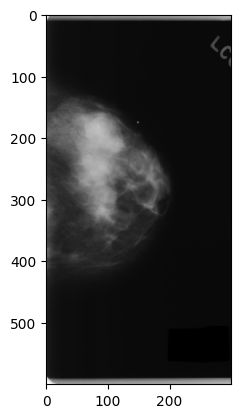

In [38]:
plt.imshow(x[0,2,:,:,:])
y

In [39]:
# 'C:/Users/marcb/Downloads/miniddsm2/MINI-DDSM-Complete-JPEG-8-valid',
# val_datagen = ImageDataGenerator(rescale=1. / 255) 	

# valid_generator =multiple_image_data_generator(val_datagen,
#                                                 'D:/Datasets/Breast/Miniddsm-53gb/archive/MINI-DDSM-Complete-JPEG-8-valid',
#                                                  4, height, width)
#valid_generator =single_image_data_generator(val_datagen,
#                                                'D:/Datasets/Breast/Miniddsm-53gb/archive/MINI-DDSM-Complete-JPEG-8-valid',
#                                                 4, height, width)
# valid_generator = val_datagen.flow_from_directory(
#     'D:/Datasets/Breast/Miniddsm-53gb/archive/MINI-DDSM-Complete-JPEG-8-valid',
#     target_size=(600,300), 
#     interpolation="lanczos",
#     color_mode='rgb', 
#     batch_size=4, 
#     class_mode='categorical', 
#     shuffle=True)
    

model = Sequential()
model.add(base_model)
#model.add()
#model.add(Flatten())
#model.add(Dense(256,activation='PReLU'))
#model.add(Dropout(.5))
#model.add(BatchNormalization())
#model.add(Dense(256,activation='PReLU'))
#model.add(Dropout(.5))
#model.add(BatchNormalization())
#model.add(Dense(128,activation='PReLU'))
#model.add(Dropout(.5))
#model.add(BatchNormalization())

#model.add(Dense(3,activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 12)                120064119 
                                                                 
 dense_32 (Dense)            (None, 256)               3584      
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_14 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_33 (Dense)            (None, 256)               66048     
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                      

# Architecture

In [40]:
from sklearn.metrics import roc_auc_score
def auc_score(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred)
def auc(y_true, y_pred):
    return tf.numpy_function(auc_score, (y_true, y_pred), tf.double)
#in model.compile you can use auc function name

In [41]:
batch_size=4
n_train=8800
n_test=879
n_train

8800

In [42]:
from tensorflow.keras import metrics

base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),loss='categorical_crossentropy', 
              metrics=[
                          'categorical_accuracy', 'AUC'
                      ])
base_model.fit(
        train_generator,
        steps_per_epoch=round(n_train /(4*batch_size)),
        epochs=90,
        validation_data=val_generator,
        validation_steps=round(n_test /(4*batch_size)))

Found 6588 images belonging to 3 classes.
Epoch 1/90
550/550 [==============================] - 285s 464ms/step - loss: 8.4473 - categorical_accuracy: 0.8786 - auc: 0.9221 - val_loss: 25.5883 - val_categorical_accuracy: 1.0000 - val_auc: 0.5958
Epoch 2/90
550/550 [==============================] - 233s 423ms/step - loss: 9.2294 - categorical_accuracy: 0.9400 - auc: 0.8300 - val_loss: 19.8906 - val_categorical_accuracy: 1.0000 - val_auc: 0.6062
Epoch 3/90
550/550 [==============================] - 221s 403ms/step - loss: 9.3882 - categorical_accuracy: 0.9782 - auc: 0.6218 - val_loss: 9.7038 - val_categorical_accuracy: 1.0000 - val_auc: 0.6233
Epoch 4/90
550/550 [==============================] - 222s 403ms/step - loss: 9.2102 - categorical_accuracy: 0.9868 - auc: 0.6249 - val_loss: 9.9359 - val_categorical_accuracy: 1.0000 - val_auc: 0.6241
Epoch 5/90
550/550 [==============================] - 225s 410ms/step - loss: 9.1506 - categorical_accuracy: 0.9918 - auc: 0.6350 - val_loss: 15.256

Epoch 41/90
550/550 [==============================] - 210s 382ms/step - loss: 9.2104 - categorical_accuracy: 1.0000 - auc: 0.6250 - val_loss: 9.7428 - val_categorical_accuracy: 1.0000 - val_auc: 0.6237
Epoch 42/90
550/550 [==============================] - 211s 384ms/step - loss: 9.2104 - categorical_accuracy: 1.0000 - auc: 0.6250 - val_loss: 9.8832 - val_categorical_accuracy: 1.0000 - val_auc: 0.6225
Epoch 43/90
550/550 [==============================] - 211s 383ms/step - loss: 9.2104 - categorical_accuracy: 1.0000 - auc: 0.6250 - val_loss: 10.1124 - val_categorical_accuracy: 1.0000 - val_auc: 0.6190
Epoch 44/90
550/550 [==============================] - 210s 382ms/step - loss: 9.2104 - categorical_accuracy: 1.0000 - auc: 0.6250 - val_loss: 9.3315 - val_categorical_accuracy: 1.0000 - val_auc: 0.6271
Epoch 45/90
550/550 [==============================] - 211s 384ms/step - loss: 9.2104 - categorical_accuracy: 1.0000 - auc: 0.6250 - val_loss: 9.7018 - val_categorical_accuracy: 1.0000 - 

550/550 [==============================] - 215s 391ms/step - loss: 17.5322 - categorical_accuracy: 1.0000 - auc: 0.6269 - val_loss: 17.5633 - val_categorical_accuracy: 1.0000 - val_auc: 0.6193
Epoch 82/90
550/550 [==============================] - 215s 391ms/step - loss: 17.5322 - categorical_accuracy: 1.0000 - auc: 0.6269 - val_loss: 17.6785 - val_categorical_accuracy: 1.0000 - val_auc: 0.6195
Epoch 83/90
550/550 [==============================] - 216s 393ms/step - loss: 17.5322 - categorical_accuracy: 1.0000 - auc: 0.6269 - val_loss: 17.5576 - val_categorical_accuracy: 1.0000 - val_auc: 0.6201
Epoch 84/90
550/550 [==============================] - 218s 396ms/step - loss: 17.5322 - categorical_accuracy: 1.0000 - auc: 0.6269 - val_loss: 16.8316 - val_categorical_accuracy: 1.0000 - val_auc: 0.6292
Epoch 85/90
550/550 [==============================] - 241s 439ms/step - loss: 17.5322 - categorical_accuracy: 1.0000 - auc: 0.6269 - val_loss: 16.9761 - val_categorical_accuracy: 1.0000 - val

In [ ]:

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    'D:/Datasets/Breast/Miniddsm-53gb/archive/MINI-DDSM-Complete-JPEG-8-test',
    target_size=(600,300), 
    interpolation="lanczos",
    color_mode='rgb', 
    batch_size=16, 
    class_mode='categorical', 
    shuffle=True)

#y_pred=model.predict_on_batch(test_datagen)
test_evaluation = model.evaluate(test_generator,verbose = 0)



In [ ]:
for i in range(0,len(model.metrics_names)):
    print("%s%s: %.2f%%" % (" ",model.metrics_names[i], test_evaluation[i]*100))


#print("Final Model Accuracy = ", (test_acc))
#print('Accuracy:', test_evaluation.accuracy_score())
#print('Precision:', test_evaluation.precision_score())
#print('Recall:', np.round(metrics.recall_score(y_test[:,0],y_pred, average='weighted'),5))
#print('F1 Score:', np.round(metrics.f1_score(y_test[:,0], y_pred, average='weighted'),5))
#print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test[:,0], y_pred,multi_class='ovo', average='weighted'),5))
#print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test[:,0], y_pred),5))
#print('\t\tClassification Report:\n', metrics.classification_report(y_test[:,0], y_pred,target_names=target))